<a href="https://colab.research.google.com/github/johnjustine5646/Ada_miniproject/blob/main/ADA_ETEC3_2348522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Adding necessary Libraries**

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio

### **Mounting the drive to access 4500 audio files**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/SpeakerIdentification

/content/drive/MyDrive/SpeakerIdentification


In [4]:
!pwd

/content/drive/MyDrive/SpeakerIdentification


In [10]:
!unzip "/content/drive/MyDrive/SpeakerIdentification/archive(11).zip"

Streaming output truncated to the last 5000 lines.
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/556.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/557.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/558.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/559.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/56.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/560.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/561.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/562.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/563.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/564.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/565.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/566.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/567.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/568.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/569.wav  
  inflating: 16000_pcm_speeches/Jens_Stoltenberg/57.wav  
  infla

### **Removing two speaker data for better working with the model, we will use 3 speakers in total, i.e Benjamin Netheyau, Nelson Mandela, Jens Stoletnberg**

In [12]:
# !rm -rf "/content/drive/MyDrive/SpeakerIdentification/16000_pcm_speeches/Magaret_Tarcher"
# !rm -rf "/content/drive/MyDrive/SpeakerIdentification/16000_pcm_speeches/Julia_Gillard"

### **Accessing Speaker audio and Background noises through sperate folders**

In [5]:
DATASET_ROOT = r"/content/drive/MyDrive/SpeakerIdentification/16000_pcm_speeches"

AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

### **Setting some hyperparameters**

In [6]:
VALID_SPLIT = 0.1

SHUFFLE_SEED = 43

SAMPLING_RATE = 16000

SCALE = 0.5

BATCH_SIZE = 128

EPOCHS = 10

### **Moving files to the correct folder**

In [7]:
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:

            continue
        elif folder in ["other", "_background_noise_"]:

            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:

            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

### **Visualization of a Wav file**

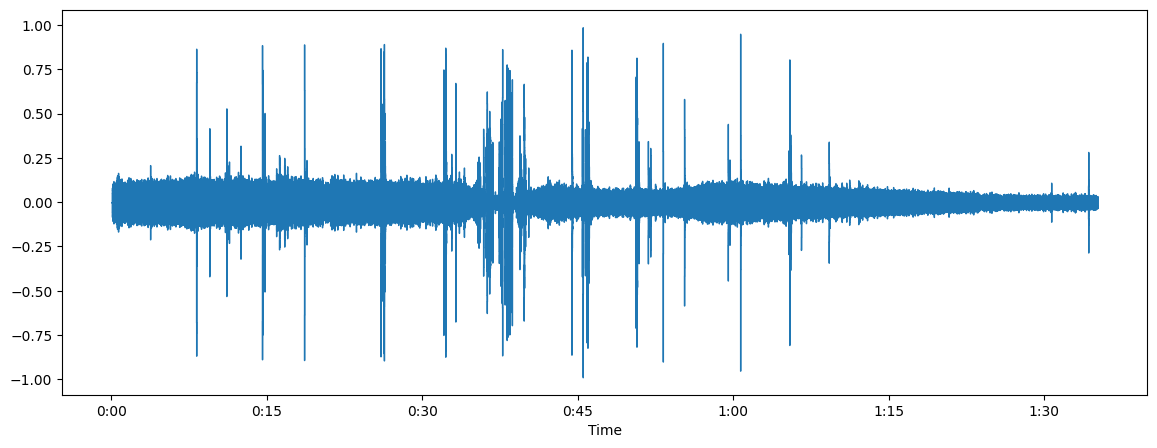

In [ ]:
import librosa.display
plt.figure(figsize = (14,5))
librosa.display.waveshow(x, sr = sr)

### **Checking final destination and status of the folders**

In [8]:
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print("Found {} files belonging to {} directories".format(len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))))

Found 6 files belonging to 2 directories


### **Preprocessing the audio folders for training**

In [9]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)


def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:

        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


### **Dataset Creation, Training ds, Testing ds, Validation ds**

In [48]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:

        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)


        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)


        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):

    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)


    return tf.math.abs(fft[:, : (audio.shape[1]), :])




class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)


rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)


num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]


train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)





train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))
print("--------")
print(train_ds)


valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

Our class names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Nelson_Mandela']
Processing speaker Benjamin_Netanyau
Processing speaker Jens_Stoltenberg
Processing speaker Nelson_Mandela
Found 4498 files belonging to 3 classes.
Using 4049 files for training.
Using 449 files for validation.
--------
<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## **RNN Model**

In [35]:
def build_rnn_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")
    x = keras.layers.LSTM(64, return_sequences=True)(inputs)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.models.Model(inputs=inputs, outputs=outputs)

rnn_model = build_rnn_model((SAMPLING_RATE, 1), len(class_names))
rnn_model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
rnn_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16000, 64)           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,885 (230.02 KB)

 Trainable params: 58,885 (230.02 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

# Initialize a counter
evaluation_counter = 0

def evaluate_model(model, dataset, class_names, display_metrics=True):
    global evaluation_counter
    evaluation_counter += 1

    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    for audios, labels in dataset:
        y_prob = model.predict(audios)  # Get the predicted probabilities
        y_pred = np.argmax(y_prob, axis=-1)  # Convert probabilities to predicted classes

        all_y_true.extend(labels.numpy())
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    # Accuracy
    accuracy = accuracy_score(all_y_true, all_y_pred)

    # Precision, Recall, F1 score (for each class)
    precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted')

    # ROC-AUC score (for multi-class classification)
    try:
        roc_auc = roc_auc_score(all_y_true, all_y_prob, multi_class='ovr', average='weighted')
    except ValueError as e:
        print(f"ROC-AUC Error: {e}")
        roc_auc = None

    if display_metrics:
        print(f"Evaluation {evaluation_counter}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC-AUC Score: {roc_auc:.4f}")
        else:
            print("ROC-AUC Score: Could not be calculated due to an error.")

    # Return the computed metrics
    return accuracy, precision, recall, f1, roc_auc

In [40]:
def fit_rnn_model(model, train_ds, valid_ds, epochs=10):
    earlystopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
    mdlcheckpoint_cb = ModelCheckpoint("rnn_model.keras", monitor="val_accuracy", save_best_only=True)

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[earlystopping_cb, mdlcheckpoint_cb]
    )
    return history

# Fit the RNN model
rnn_history = fit_rnn_model(rnn_model, train_ds, valid_ds)

# Evaluate the RNN model
rnn_eval = rnn_model.evaluate(valid_ds)
print(f'RNN Model Evaluation: {rnn_eval}')


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3376 - loss: 1.4277 - val_accuracy: 0.3474 - val_loss: 1.1046
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3424 - loss: 1.1034 - val_accuracy: 0.3051 - val_loss: 1.1042
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3389 - loss: 1.1030 - val_accuracy: 0.3051 - val_loss: 1.1023
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3462 - loss: 1.1009 - val_accuracy: 0.3051 - val_loss: 1.1147
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3252 - loss: 1.1037 - val_accuracy: 0.3942 - val_loss: 1.0861
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4444 - loss: 1.0464 - val_accuracy: 0.4655 - val_loss: 1.0142
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4640 - loss: 1.0223 - val_accuracy: 0.3474 - val_loss: 1.1318
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3404 - loss: 1.1141 - val_accuracy: 0.3051 - val_loss:

In [60]:
accuracy, precision, recall, f1, roc_auc = evaluate_model(rnn_model, valid_ds, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
ROC-AUC Error: Number of classes in y_true not equal to the number of columns in 'y_score'
Evaluation 1:
Accuracy: 0.4499
Precision: 0.3087
Recall: 0.4499
F1 Score: 0.3616
ROC-AUC Score: Could not be calculated due to an error.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RNN models with low accuracy

## **CNN Model**

In [34]:
def build_cnn_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")
    x = keras.layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Conv1D(64, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.models.Model(inputs=inputs, outputs=outputs)

cnn_model = build_cnn_model((SAMPLING_RATE, 1), len(class_names))
cnn_model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 15996, 32)           │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 7998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 7994, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 3997, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 255808)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      32,743,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,754,693 (124.95 MB)

 Trainable params: 32,754,693 (124.95 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def fit_cnn_model(model, train_ds, valid_ds, epochs=10):
    earlystopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
    mdlcheckpoint_cb = ModelCheckpoint("cnn_model.keras", monitor="val_accuracy", save_best_only=True)

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[earlystopping_cb, mdlcheckpoint_cb]
    )
    return history

# Fit the CNN model
cnn_history = fit_cnn_model(cnn_model, train_ds, valid_ds)

# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(valid_ds)
print(f'CNN Model Evaluation: {cnn_eval}')

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 788ms/step - accuracy: 0.2772 - loss: 2.7042 - val_accuracy: 0.3474 - val_loss: 1.3848
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 750ms/step - accuracy: 0.4054 - loss: 1.1790 - val_accuracy: 0.6325 - val_loss: 0.7178
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 742ms/step - accuracy: 0.6852 - loss: 0.6286 - val_accuracy: 0.6949 - val_loss: 0.4902
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 751ms/step - accuracy: 0.7605 - loss: 0.4336 - val_accuracy: 0.8085 - val_loss: 0.3927
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 435ms/step - accuracy: 0.8218 - loss: 0.3623 - val_accuracy: 0.8018 - val_loss: 0.3897
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 717ms/step - accuracy: 0.8441 - loss: 0.3298 - val_accuracy: 0.8196 - val_loss: 0.3726
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 424ms/step - accuracy: 0.8597 - loss: 0.3048 - val_accuracy: 0.8129 - val_loss: 0.3592
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.8713 - loss: 0.2791 - val_accu

In [61]:
accuracy, precision, recall, f1, roc_auc = evaluate_model(cnn_model, valid_ds, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
ROC-AUC Error: Number of classes in y_true not equal to the number of columns in 'y_score'
Evaluation 2:
Accuracy: 0.8174
Precision: 0.8258
Recall: 0.8174
F1 Score: 0.8121
ROC-AUC Score: Could not be calculated due to an error.


### Generic CNN model producing better accuracy

### **Convolutional Recurrent Neural Network (CRNN)**

In [52]:
def build_crnn_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape)

    # Convolutional layers for feature extraction
    x = keras.layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    x = keras.layers.Conv1D(64, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)

    # RNN layers for sequence modeling
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)

    # Dense layers and output
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

crnn_model = build_crnn_model((SAMPLING_RATE, 1), len(class_names))
crnn_model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
crnn_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 16000, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 15996, 32)           │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 7998, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 7994, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 3997, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 3997, 256)           │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,651 (2.42 MB)

 Trainable params: 635,651 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Callbacks for early stopping and saving the best model
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    "crnn_model.keras", monitor="val_accuracy", save_best_only=True
)

# Training the CRNN model
history = crnn_model.fit(
    train_ds,                   # Training dataset
    epochs=10,                  # Number of epochs
    validation_data=valid_ds,   # Validation dataset
    callbacks=[earlystopping_cb, mdlcheckpoint_cb]  # Callbacks
)

# Evaluate the model on the validation dataset
evaluation_results = crnn_model.evaluate(valid_ds)
print(f"Validation Accuracy: {evaluation_results[1]:.4f}")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4541 - loss: 0.9759 - val_accuracy: 0.6236 - val_loss: 0.6630
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6158 - loss: 0.7684 - val_accuracy: 0.6437 - val_loss: 0.5656
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6596 - loss: 0.5387 - val_accuracy: 0.7016 - val_loss: 0.4949
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6767 - loss: 0.5174 - val_accuracy: 0.5546 - val_loss: 0.8751
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6244 - loss: 0.7647 - val_accuracy: 0.6592 - val_loss: 0.6007
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6525 - loss: 0.5562 - val_accuracy: 0.6748 - val_loss: 0.5193
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6577 - loss: 0.5494 - val_accuracy: 0.6860 - val_loss: 0.5880
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6907 - loss: 0.5796 - val_accuracy: 0.6659 - val_loss:

In [62]:
accuracy, precision, recall, f1, roc_auc = evaluate_model(crnn_model, valid_ds, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Evaluation 3:
Accuracy: 0.7082
Precision: 0.7057
Recall: 0.7082
F1 Score: 0.6901
ROC-AUC Score: 0.8842


### Generic CRNN model with no modification or addition with a good accuracy

### **Custom BaseLine Residual Model**

In [74]:
def residual_block(x, filters, conv_num=3, activation="relu"):

    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE, 1), len(class_names))

model.summary()


model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 16000, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 16000, 16)      │             64 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_26             │ (None, 16000, 16)      │              0 │ conv1d_45[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_46 (Conv1D)        │ (None, 16000, 16)      │            784 │ activation_26[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 16000, 16)      │             32 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 16000, 16)      │              0 │ conv1d_46[0][0],       │
│                           │                        │                │ conv1d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_27             │ (None, 16000, 16)      │              0 │ add_17[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_18          │ (None, 8000, 16)       │              0 │ activation_27[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 8000, 32)       │          1,568 │ max_pooling1d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 8000, 32)       │              0 │ conv1d_48[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 8000, 32)       │          3,104 │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_47 (Conv1D)        │ (None, 8000, 32)       │            544 │ max_pooling1d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 8000, 32)       │              0 │ conv1d_49[0][0],       │
│                           │                        │                │ conv1d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 8000, 32)       │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_19          │ (None, 4000, 32)       │              0 │ activation_29[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)   

 Total params: 5,808,083 (22.16 MB)

 Trainable params: 5,808,083 (22.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.4570 - loss: 1.0040 - val_accuracy: 0.7149 - val_loss: 0.5473
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7028 - loss: 0.4971 - val_accuracy: 0.6971 - val_loss: 0.4961
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7504 - loss: 0.4540 - val_accuracy: 0.7817 - val_loss: 0.4010
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8017 - loss: 0.3641 - val_accuracy: 0.8218 - val_loss: 0.3282
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8594 - loss: 0.2857 - val_accuracy: 0.8441 - val_loss: 0.2880
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7805 - loss: 0.5296 - val_accuracy: 0.8508 - val_loss: 0.2910
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8947 - loss: 0.2345 - val_accuracy: 0.9154 - val_loss: 0.1657
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9129 - loss: 0.1854 - val_accuracy: 0.9154 - val_loss

In [13]:
print(model.evaluate(valid_ds))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9499 - loss: 0.1024
[0.0985095351934433, 0.9599999785423279]


In [76]:
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, valid_ds, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Evaluation 9:
Accuracy: 0.9220
Precision: 0.9347
Recall: 0.9220
F1 Score: 0.9212
ROC-AUC Score: 0.9958


### Custom Baseline model producing the best accuracy, because of its domain specific modelling

### **Lets Look at some Prediction made by the model:**


*   **Green : Model prediction and actual label same**
*   **Red : Model prediction and actual label different**



In [15]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):

    ffts = audio_to_fft(audios)

    y_pred = model.predict(audios)

    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):

        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index] and model.evaluate(test_ds)[1] > 0.90:

            print(y_pred[index])
            print("Welcome")
        else:
            print("Sorry")

<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9548 - loss: 0.0982
2
Welcome
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9421 - loss: 0.1159
2
Welcome
Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9564 - loss: 0.0928
3
Welcome
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9561 - loss: 0.0918
2
Welcome
Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9582 - loss: 

### **Saving our model for later use**

In [21]:
model.save('sample.h5')

In [23]:
model = tf.keras.models.load_model('sample.h5')
# Access the input shape of the model
input_shape = model.input_shape
print(input_shape)

(None, 16000, 1)


### **If the speaker is same as the name we have provided then its says "Welcome" else it says "Sorry"**

In [18]:
test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):

    ffts = audio_to_fft(audios)

    y_pred = model.predict(audios)

    rnd = np.random.randint(0, BATCH_SIZE, 1)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):

        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index] and model.evaluate(test_ds)[1] > 0.90:
            print(model.evaluate(test_ds)[1])
            print("Welcome")
        else:
            print("Sorry")

<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.9608 - loss: 0.0940
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9433 - loss: 0.1196
0.95333331823349
Welcome


### **We gave the speaker as John, but still it recogonized the speaker rightly as Benjamin Nethnyahu**

In [27]:
path = ["/content/drive/MyDrive/SpeakerIdentification/testing/1499.wav"]
print(path)
labels = ["unknown"]



test_ds = paths_and_labels_to_dataset(path, labels)

test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

print(test_ds)
print(valid_ds)

for audios, labels in test_ds.take(1):

	y_pred = model.predict(audios)

	rnd = np.random.randint(0, 1, 1)
	audios = audios.numpy()[rnd, :]
	labels = labels.numpy()[rnd]
	y_pred = np.argmax(y_pred, axis=-1)[rnd]

	for index in range(1):

			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			a = model.evaluate(valid_ds)
			print(a[1])
			if class_names[y_pred[index]] == "John":
				print(model.evaluate(test_ds)[1])

				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])

['/content/drive/MyDrive/SpeakerIdentification/testing/1499.wav']
<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
Speaker: 2	Predicted: 2
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9550 - loss: 0.1122
0.9666666388511658
Sorry
Benjamin_Netanyau


### **Though we gave the speaker as jullia Gillard we got it as Nelson Mandela which is wrong so it said "Sorry"**

In [29]:
def paths_to_dataset(audio_paths):
	"""Constructs a dataset of audios and labels."""
	path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)

	return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
	test = paths_and_labels_to_dataset(path, labels)


	test = test.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
	BATCH_SIZE
	)
	test = test.prefetch(tf.data.experimental.AUTOTUNE)


	test = test.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

	for audios, labels in test.take(1):

		ffts = audio_to_fft(audios)

		y_pred = model.predict(ffts)

		rnd = np.random.randint(0, 1, 1)
		audios = audios.numpy()[rnd, :]
		labels = labels.numpy()[rnd]
		y_pred = np.argmax(y_pred, axis=-1)[rnd]

		for index in range(1):

			print(
				"Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
					"[92m",y_pred[index],
					"[92m", y_pred[index]
				)
			)
			if class_names[y_pred[index]] == "Julia_Gillard":
				print("Welcome")
			else:
				print("Sorry")
			print(class_names[y_pred[index]])




path = ["/content/drive/MyDrive/SpeakerIdentification/testing/970.wav"]
labels = ["unknown"]




predict(path, labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Speaker: 4	Predicted: 4
Sorry
Nelson_Mandela


### A namesake graph of how the adam optimizer was able to increase the accuracy and reduce the loss from the 2nd epoch onwards

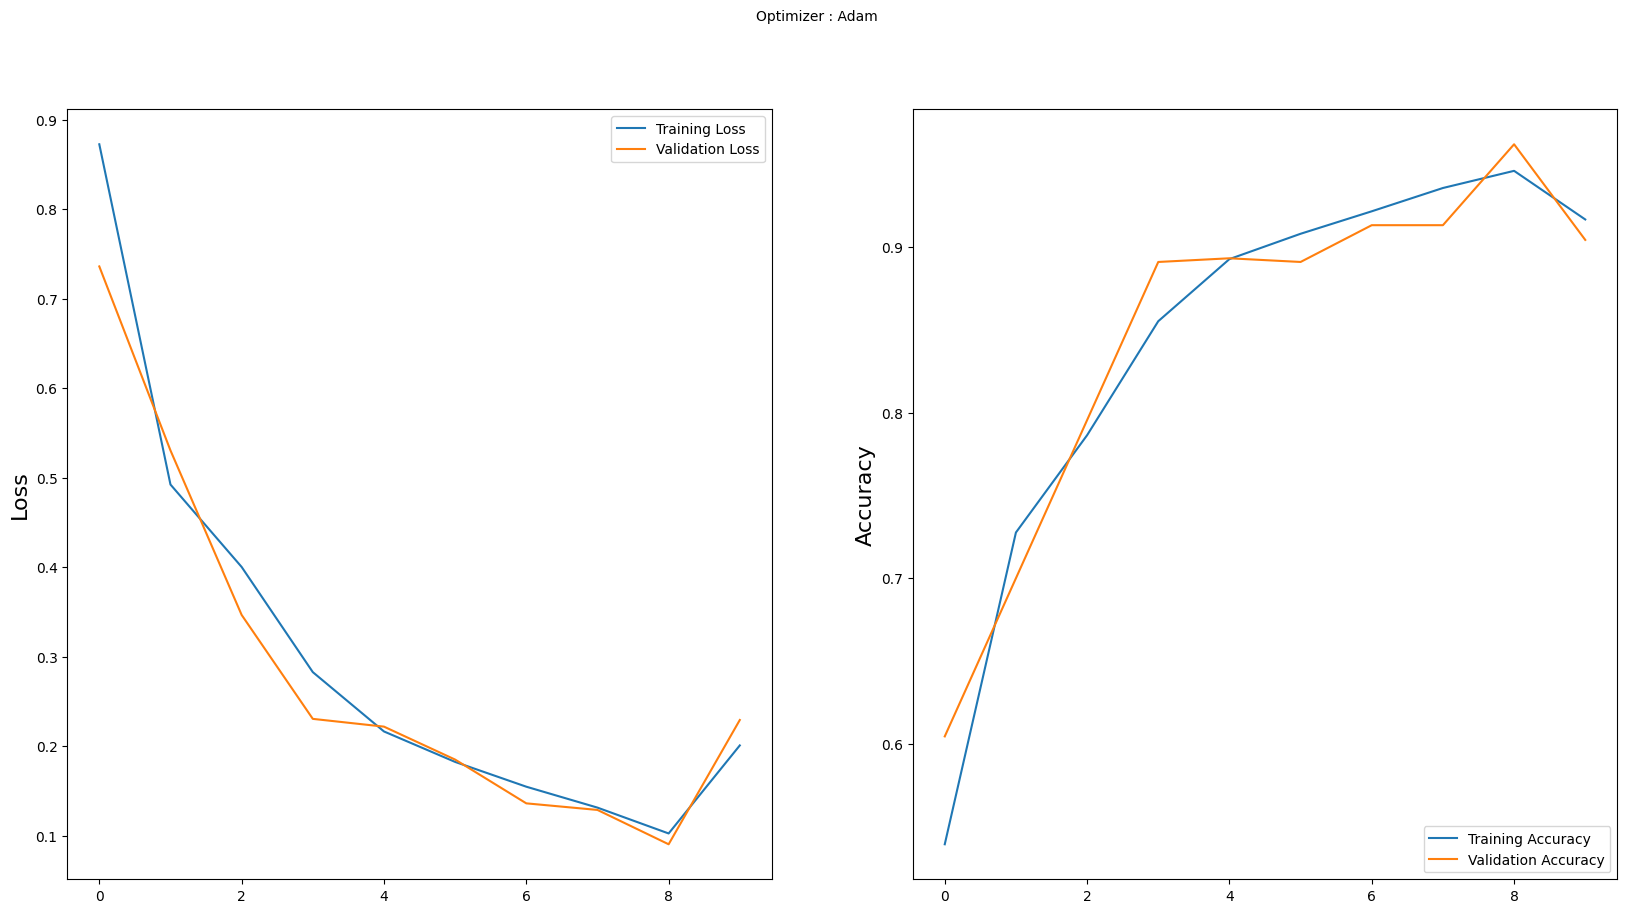

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()